https://www.salesanalytics.co.jp/datascience/datascience087/

# 必要なライブラリーの読み込み

In [2]:
# ライブラリーの読み込み
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt
# グラフのスタイルとサイズ
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

# 利用するデータ

In [3]:
# データセットの読み込み
url='https://www.salesanalytics.co.jp/591h' #データセットのあるURL
df=pd.read_csv(url,                         #読み込むデータのURL
               index_col='Month',           #変数「Month」をインデックスに設定
               parse_dates=True)            #インデックスを日付型に設定
df.head() #確認

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


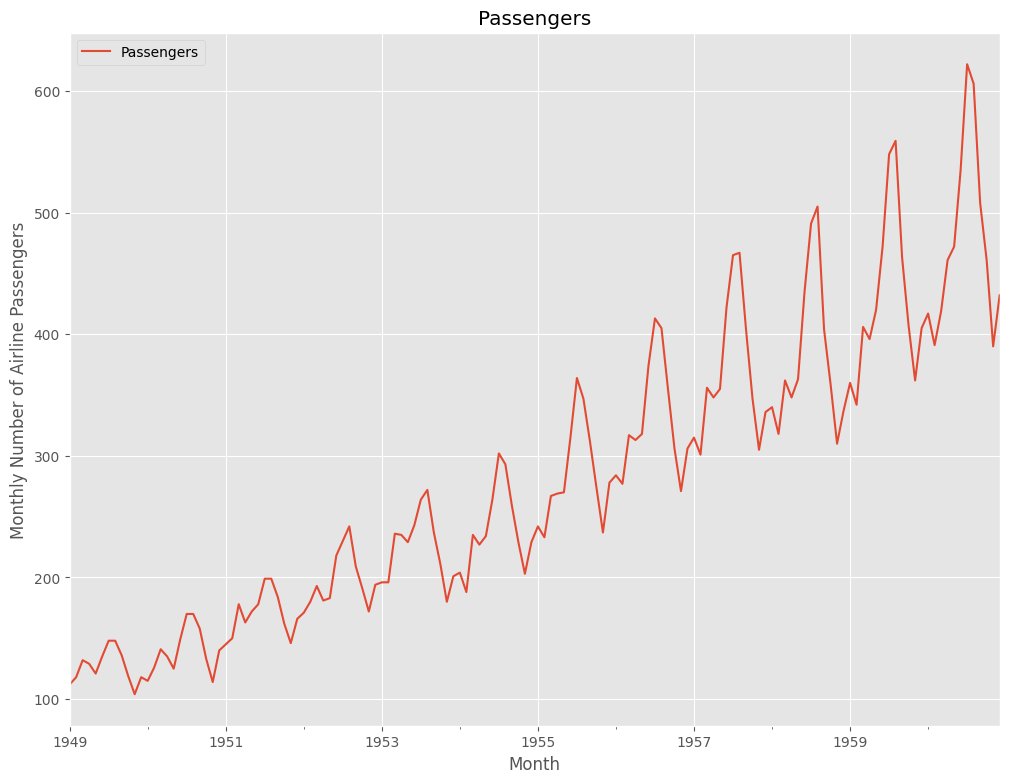

In [4]:
# プロット
df.plot()
plt.title('Passengers')                            #グラフタイトル
plt.ylabel('Monthly Number of Airline Passengers') #タテ軸のラベル
plt.xlabel('Month')                                #ヨコ軸のラベル
plt.show()

In [5]:
# 学習データとテストデータ（直近12ヶ月間）に分割
df_train, df_test = model_selection.train_test_split(df, test_size=12)

# 予測精度の評価指標

- 二乗平均平方根誤差（RMSE、Root Mean Squared Error）
- 平均絶対誤差（MAE、Mean Absolute Error）
- 平均絶対パーセント誤差（MAPE、Mean absolute percentage error）

# 原系列

## 事前検討

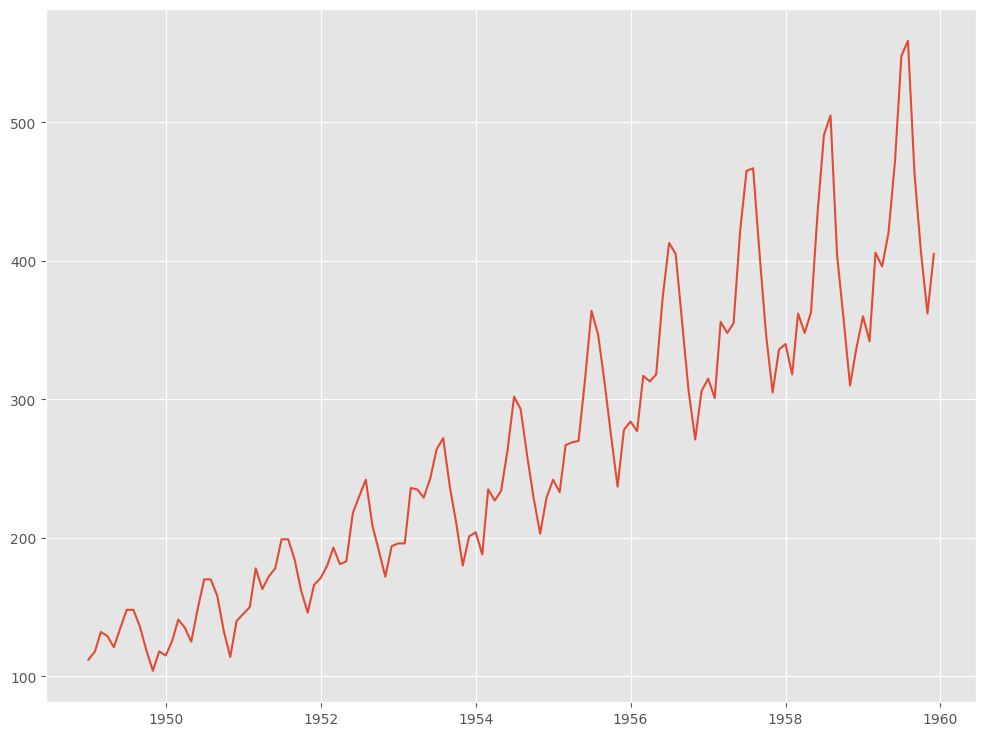

In [6]:
# 系列のプロット
plt.plot(df_train)

### 成分分解

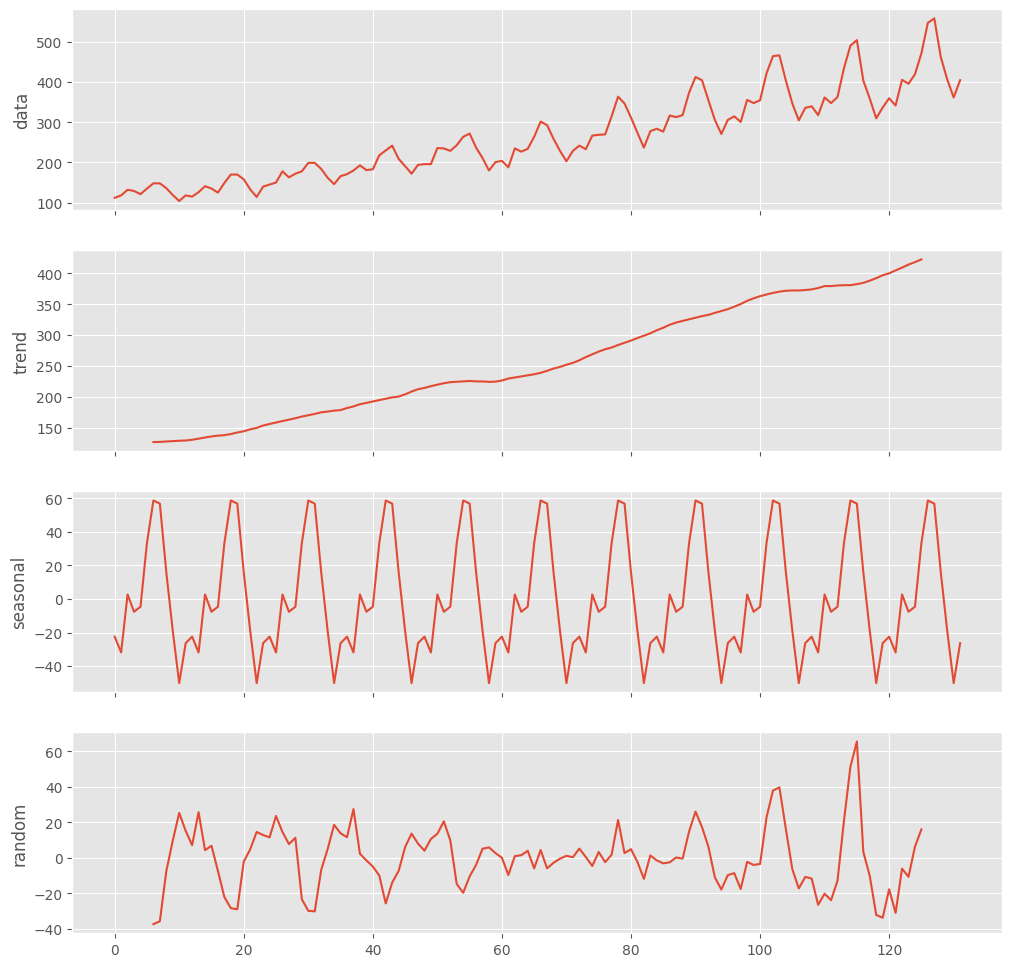

In [7]:
# 成分分解（tread・seasonal・random）
data = df_train.Passengers.values
utils.decomposed_plot(arima.decompose(data, 'additive', m=12),
                      figure_kwargs = {'figsize': (12, 12)} )

### 階差の次数を検討

In [8]:
# 階差の次数の検討
print('d =', arima.ndiffs(df))      #d
print('D =',arima.nsdiffs(df,m=12)) #D

d = 1
D = 1


これは、単位根検定などの定常性の統計的仮説検定を実施した結果です。通常の階差の次数は1で、季節階差の次数も1です。

前期との差分から階差系列（1次）を求め、さらに12期前（1年前）との差分から季節階差系列（1次）を求めます。このデータのコレログラムを求めます。

/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


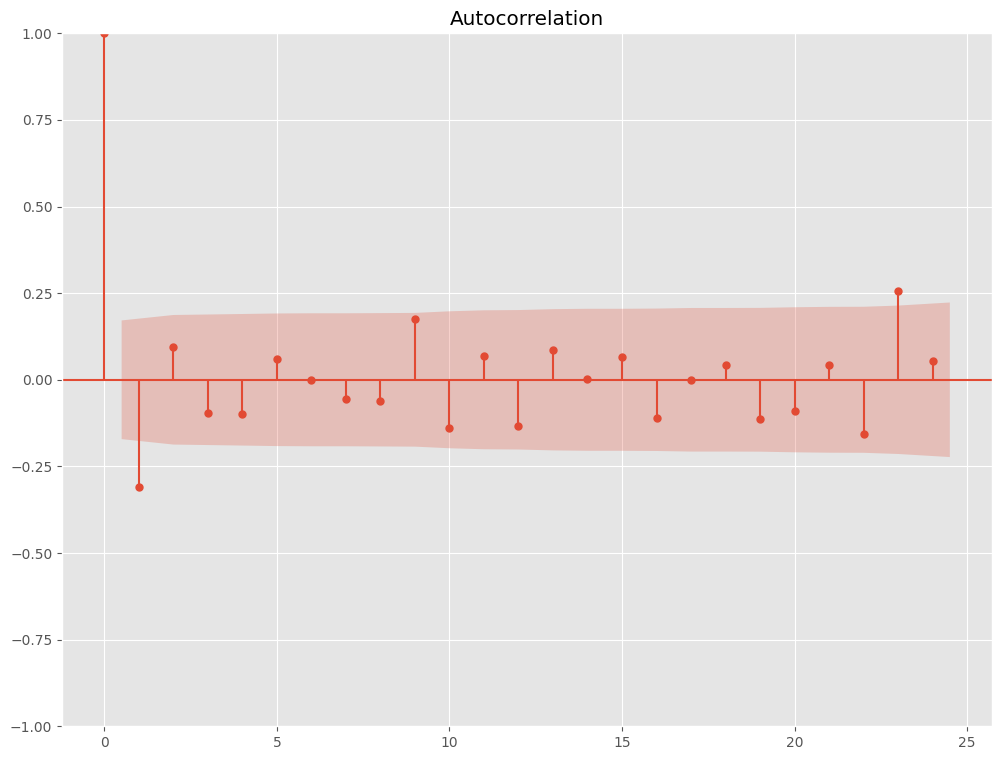

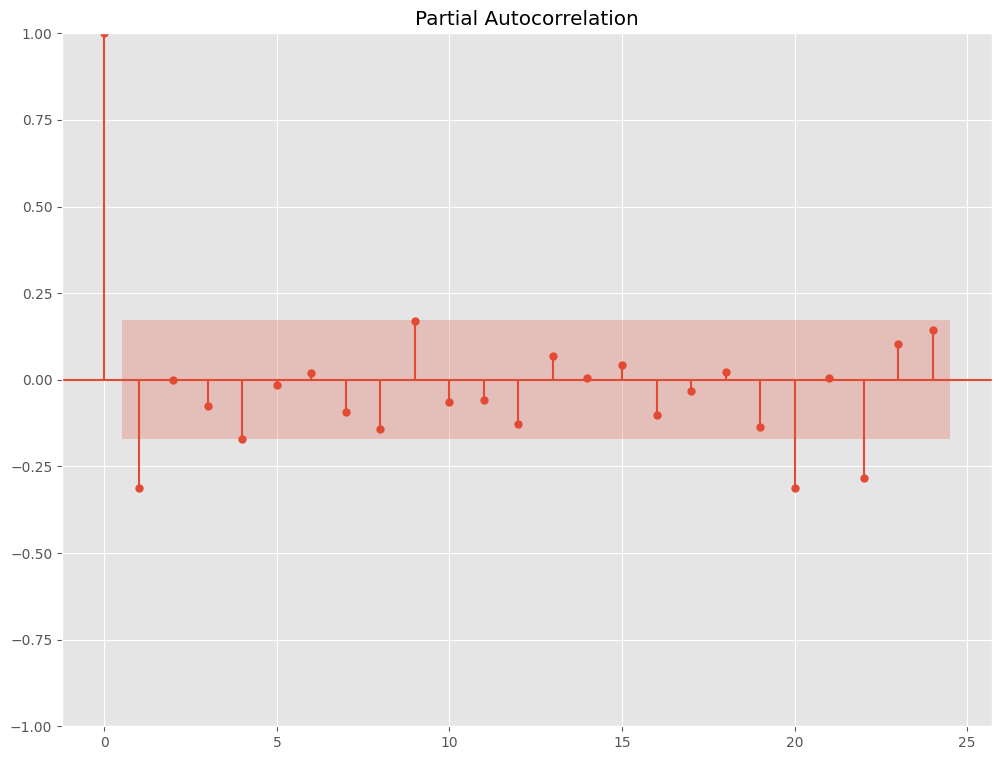

In [9]:
# コレログラム（自己相関と偏自己相関）
data = df.diff(1).diff(12).dropna()
utils.plot_acf(data, alpha=.05, lags=24)
utils.plot_pacf(data, alpha=.05, lags=24)

このコレログラムをどう読み解くか、という問題はありますが、一旦ARとMAの次数を1とします。

# 手動構築（SARIMAX関数）

ここまでの結果から、次数を以下のように考えます。

非季節性
- AR：p=1
- 階差：d=1
- MA：q=1

季節性
- 季節AR：P=0
- 季節階差：D=1
- 季節MA：Q=0

では、statsmodelsライブラリーのSARIMAX関数を利用し、ARIMAモデルを学習します。

In [10]:
# 原系列を学習データとする
train = df_train
# 学習
sarima_model = SARIMAX(train, order=(1, 1, 1), 
                       seasonal_order=(0, 1, 0,12))
sarima_fit = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39063D+00    |proj g|=  7.28451D-03

At iterate    5    f=  3.39006D+00    |proj g|=  6.33321D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   3.473D-07   3.390D+00
  F =   3.3900429508851091     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


学習し構築したモデルを使い予測をします。

In [11]:
# 予測
##学習データの期間の予測値
train_pred = sarima_fit.predict()
##テストデータの期間の予測値
test_pred = sarima_fit.forecast(len(df_test))
##予測区間
test_pred_ci = sarima_fit.get_forecast(len(df_test)).conf_int() 
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test, test_pred))

RMSE:
24.809438526765287
MAE:
19.561469046990595
MAPE:
0.04415712466196478


結果をグラフで視覚的に確認します。

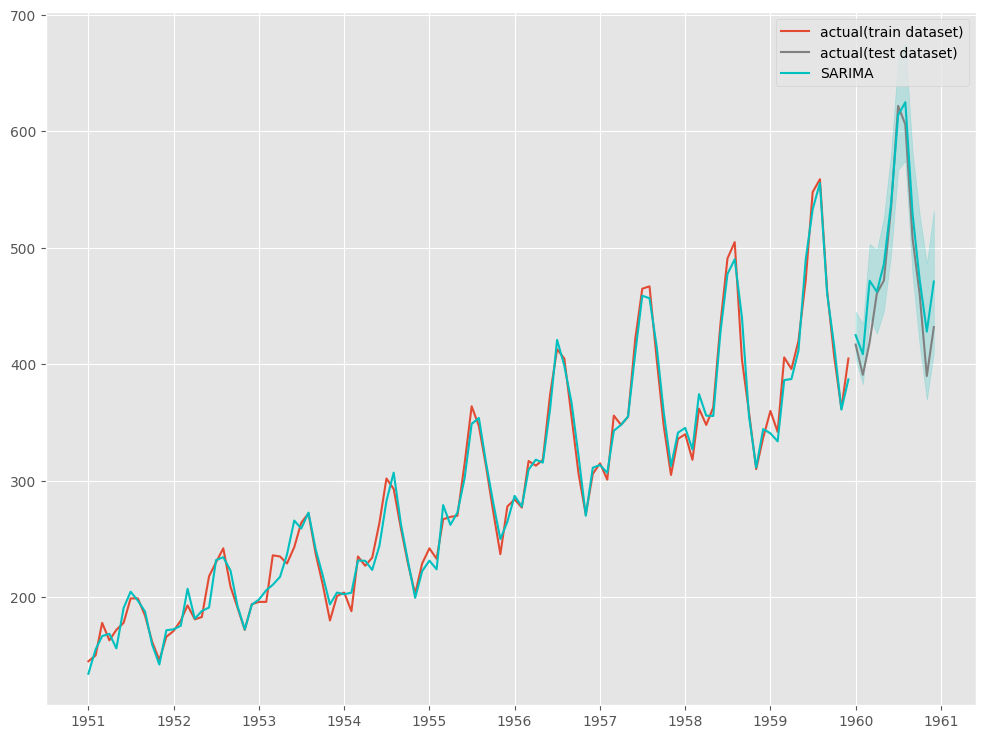

In [12]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, train_pred[24:].values, color="c")
ax.plot(df_test.index, test_pred.values, label="SARIMA", color="c") 
ax.fill_between(
    df_test.index,
    test_pred_ci.iloc[:, 0],
    test_pred_ci.iloc[:, 1],
    color='c',
    alpha=.2)
ax.legend()

# 自動構築（auto_arima関数）

次数を事前に設定せず、pmdarimaライブラリーのauto_arima関数を使い、ARIMAモデルを自動構築します。

In [13]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(train, 
                            seasonal=True,
                            m=12,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=911.913, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.865, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.556, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.723, Time=0.24 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=909.369, Time=0.13 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.124, Time=0.10 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=911.772, Time=0.25 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.870, Time=0.09 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.478, Time=0.14 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.05 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.717, Time=0.12 sec
 ARIMA(2,0,0)(1,1,1)[12] inter

SARIMA(3,0,0)(0,1,0,12)というARIMAモデルが構築されました。このモデルを使い予測をします。

In [14]:
# 予測
##学習データの期間の予測値
train_pred = arima_model.predict_in_sample()
##テストデータの期間の予測値
test_pred, test_pred_ci = arima_model.predict(
    n_periods=df_test.shape[0], 
    return_conf_int=True
)
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test, test_pred))

RMSE:
18.536468798006823
MAE:
14.898208317448123
MAPE:
0.030975615303185346


結果をグラフで視覚的に確認します。

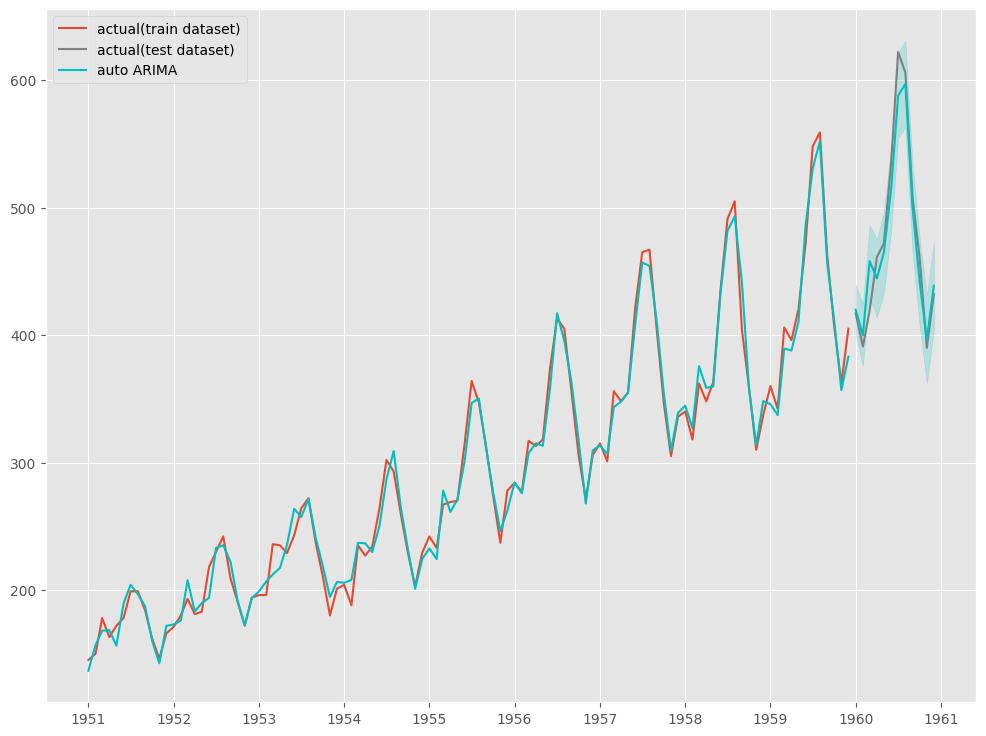

In [15]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, train_pred[24:], color="c")
ax.plot(df_test.index, test_pred, label="auto ARIMA", color="c") 
ax.fill_between(
    df_test.index,
    test_pred_ci[:, 0],
    test_pred_ci[:, 1],
    color='c',
    alpha=.2)
ax.legend()

# 　ハイブリッド構築（階差の次数のみ指定）

差の次数のみ指定し、auto_arima関数を使い、ARIMAモデルを構築します。

In [17]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(train, 
                            seasonal=True,
                            m=12,
                            d=1,
                            D=1,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=903.866, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=905.065, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=900.823, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=901.721, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=899.902, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=901.052, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=900.758, Time=0.10 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=901.337, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=900.971, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=900.685, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=902.976, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=901.457, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.690 seconds


In [18]:
# 予測
##学習データの期間の予測値
train_pred = arima_model.predict_in_sample()
##テストデータの期間の予測値
test_pred, test_pred_ci = arima_model.predict(
    n_periods=df_test.shape[0], 
    return_conf_int=True
)
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test, test_pred))

RMSE:
23.93167319781741
MAE:
18.527652990128036
MAPE:
0.04182388631290588


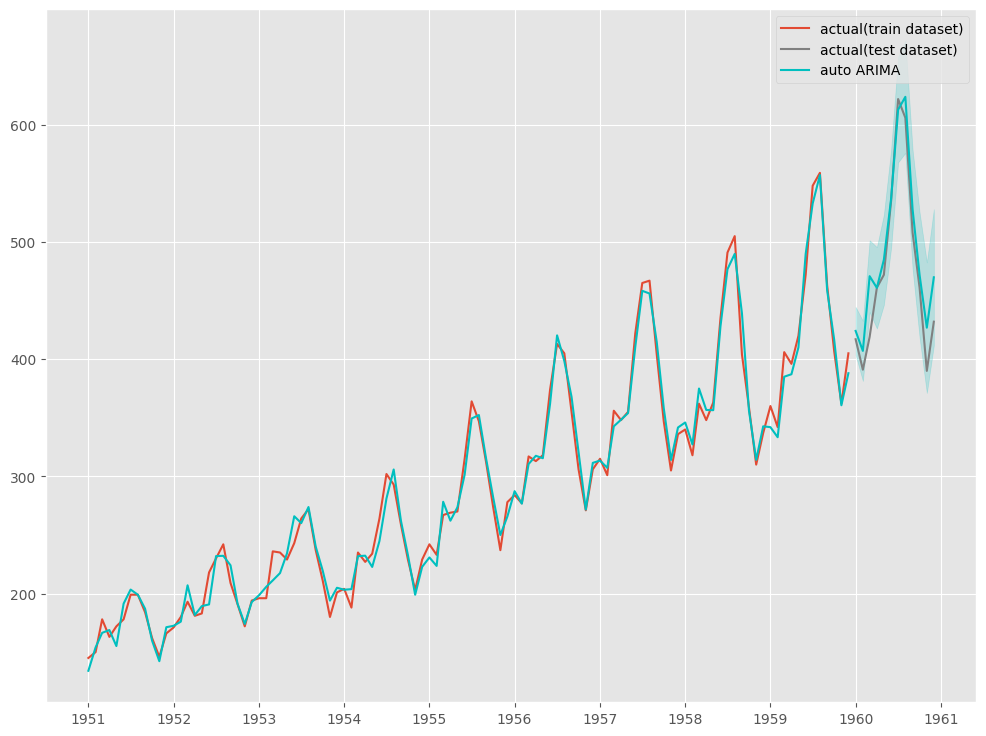

In [19]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, train_pred[24:], color="c")
ax.plot(df_test.index, test_pred, label="auto ARIMA", color="c") 
ax.fill_between(
    df_test.index,
    test_pred_ci[:, 0],
    test_pred_ci[:, 1],
    color='c',
    alpha=.2)
ax.legend()